In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 100

## Loading the MNIST dataset and preprocessing it

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 [==============================] - 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Creating the discriminator and generator





In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

110 11


In [ ]:
def get_discriminator(image_size, discriminator_in_channels):    
    inp = keras.layers.Input((image_size, image_size, discriminator_in_channels))
    
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(inp)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(1)(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)
    return model

In [ ]:
discriminator = get_discriminator(image_size, discriminator_in_channels)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 11)]      0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                             

In [ ]:
def get_generator(generator_in_channels, num_channels):    
    inp = keras.layers.Input((100 + 10,))
    x = layers.Dense(7 * 7 * generator_in_channels)(inp)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((7, 7, generator_in_channels))(x)

    x = layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(num_channels, kernel_size=7, padding="same", activation="sigmoid")(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)    
    return model

In [ ]:
generator = get_generator(generator_in_channels, num_channels)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 110)]             0         
                                                                 
 dense_1 (Dense)             (None, 5390)              598290    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5390)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 110)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      225408    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

## Loss

In [ ]:
bce_obj = keras.losses.BinaryCrossentropy(from_logits=True)
def loss_fn(labels, predictions):
    loss = bce_obj(labels, predictions)
    return loss


In [ ]:
d_optimizer=keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer=keras.optimizers.Adam(learning_rate=0.0003)

## Train

In [ ]:
def generated_image(generator, latent_dim):
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    one_hot_labels = keras.utils.to_categorical(labels, 10)
    
    random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
    random_vector_labels = tf.concat(
        [random_latent_vectors, one_hot_labels], axis=1)
    generated_images = generator(random_vector_labels)
    generated_images.numpy()
    show_list = []
    for i in range(10):
        show_list.append(np.squeeze(generated_images[i]))
    plt.figure(figsize=(10, 10))
    plt.imshow(np.concatenate(show_list, axis=1), cmap="Greys_r")
    plt.show()

In [ ]:
@tf.function(experimental_relax_shapes=True)
def train_step(data):
    # Unpack the data.
    real_images, one_hot_labels = data

    # Add dummy dimensions to the labels so that they can be concatenated with
    # the images. This is for the discriminator.
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(image_one_hot_labels, 
                                     repeats=[image_size * image_size])
    image_one_hot_labels = tf.reshape(image_one_hot_labels, 
                                      (-1, image_size, image_size, num_classes))

    # Sample random points in the latent space and concatenate the labels.
    # This is for the generator.
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # Decode the noise (guided by labels) to fake images.
    generated_images = generator(random_vector_labels)

    # Combine them with real images. Note that we are concatenating the labels
    # with these images here.
    fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
    real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
    combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

    # Assemble labels discriminating real from fake images.
    labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

    # Train the discriminator.
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    
    
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # Assemble labels that say "all real images".
    misleading_labels = tf.ones((batch_size, 1))

    # Train the generator 
    with tf.GradientTape() as tape:
        fake_images = generator(random_vector_labels)
        fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
        predictions = discriminator(fake_image_and_labels)
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return d_loss, g_loss

In [ ]:
def fit(train_ds, epochs):
    for epoch in range(epochs):
        for data in train_ds:                      
            d_loss, g_loss = train_step(data)
        
        #checkpoint.save(file_prefix = checkpoint_prefix)
        generated_image(generator, latent_dim)
        print('epoch: {} d_loss {}  g_loss: {}'.format(epoch, d_loss, g_loss))


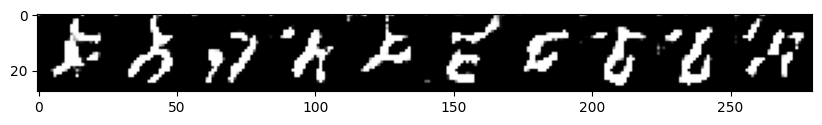

epoch: 0 d_loss 0.4395521581172943  g_loss: 1.5333853960037231


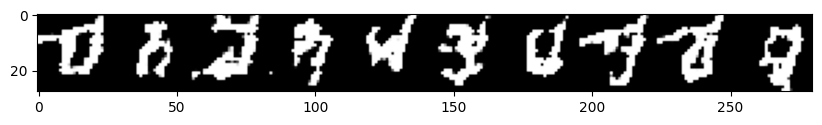

epoch: 1 d_loss 0.412138968706131  g_loss: 1.5291272401809692


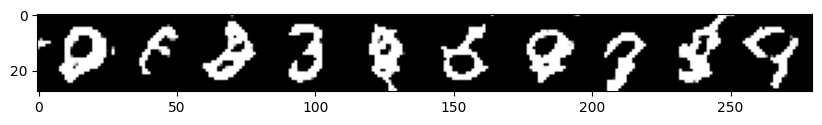

epoch: 2 d_loss 0.46776676177978516  g_loss: 1.696175217628479


KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 10 
fit(dataset, EPOCHS)